## Imports

In [2]:
import pickle
import sys
import tempfile
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

In [3]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [4]:
import python.utils
import python.model

In [5]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [6]:
%load_ext autoreload
%autoreload 2

## Parameters

In [7]:
NOTEBOOK_PATH = Path("train_bert").resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_bert')

In [8]:
device = torch.device("cuda:1")
cpu = torch.device("cpu")

### Load data

In [9]:
try:
    with Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name, "train_data.pkl").open("rb") as fin:
        TRAIN_TEST_SPLITS = pickle.load(fin)
except FileNotFoundError:
    %run prepare_training_data.ipynb
    temp_data_path = Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name)
    temp_data_path.mkdir(exist_ok=True)
    with temp_data_path.joinpath("train_data.pkl").open("wb") as fout:
        pickle.dump(TRAIN_TEST_SPLITS, fout, pickle.HIGHEST_PROTOCOL)

In [10]:
train_df, valid_df = TRAIN_TEST_SPLITS[-1]

### Configure model

In [11]:
%%file {NOTEBOOK_PATH}/model.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class XTXDataset(Dataset):
    def __init__(self, data, num_previous=1) -> None:
        super().__init__()
        assert num_previous > 0
        values = data[:, :-1]
        targets = data[:, -1:]

        values = np.flip(values, 0)
        targets = np.flip(targets, 0)

        #         self.values = values.reshape(values.shape[0], 4, 15).transpose([1, 2, 0]).copy()
        self.values = values.copy()
        self.targets = targets.copy()

        self.num_previous = num_previous

    def __len__(self):
        return self.targets.shape[0] - self.num_previous + 1

    def __getitem__(self, index):
        #         values = self.values[:, :, index : index + self.num_previous]
        #         targets = self.targets[index : index + self.num_previous, :]
        values = self.values[index : index + self.num_previous, :]
        targets = self.targets[index : index + self.num_previous, :]

        #         perm = np.arange(15)
        #         np.random.shuffle(perm)
        #         values = values[:, perm, :]

        return values, targets


class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_previous):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_previous, d_model)
        position = torch.arange(0, max_previous).unsqueeze(1).to(torch.float32)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).to(torch.float32)
            * -(np.log(max_previous * 2) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #         pe = torch.flip(pe, (0,))
        #         pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        #         x = x + self.pe[:, -x.size(1) :]
        x = x + self.pe[:, : x.size(-1)]
        x = self.dropout(x)
        return x


class XTXModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        d_model=512,
        nhead=8,
        num_encoder_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        num_previous=100,
    ):
        super().__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_size, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
            nn.LayerNorm(d_model),
        )

        self.pe = PositionalEncoding(d_model, dropout, num_previous)

        self.input_norm = nn.BatchNorm1d(num_previous)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            custom_decoder=None,
        )

        self.dropout_out = nn.Dropout(dropout)
        self.norm_out = nn.BatchNorm1d(num_previous)

        self.linear_out = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_size),
        )

        self.d_model = d_model

    def encoder(
        self, x, src_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None
    ):
        x = self.embedding(x)
        #         x = self.input_norm(x)
        x = self.pe(x)
        src = x.transpose(0, 1)

        if src.size(2) != self.d_model:
            raise RuntimeError(
                "the feature number of src and tgt must be equal to d_model"
            )

        memory = self.transformer.encoder(
            src, mask=src_mask, src_key_padding_mask=src_key_padding_mask
        )
        src = src + self.dropout_out(memory)
        output = src.transpose(0, 1)
        return output

    def forward(
        self, x, src_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None
    ):
        output = self.encoder(x)
        output = self.norm_out(output)
        output = self.linear_out(output)
        return output


class XTXModel2(nn.Module):
    def __init__(self, d_model, output_size, dim_feedforward, transformer, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.linear_out = nn.Sequential(
#             nn.Linear(d_model, output_size),
            nn.Linear(d_model * 2, dim_feedforward),
            nn.LayerNorm(dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_size),
        )

        for param in transformer.parameters():
            param.requires_grad = False
        self.transformer = transformer

    def forward(self, x):
        x = self.transformer.encoder(x)
        x = torch.cat([x[:, :-1, :], x[:, 1:, :]], dim=2)
        x = self.dropout(x)
        x = self.linear_out(x)
        return x

Overwriting /home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_bert/model.py


In [12]:
%run {NOTEBOOK_PATH}/model.py

In [13]:
pe = PositionalEncoding(128, 0.1, 200)

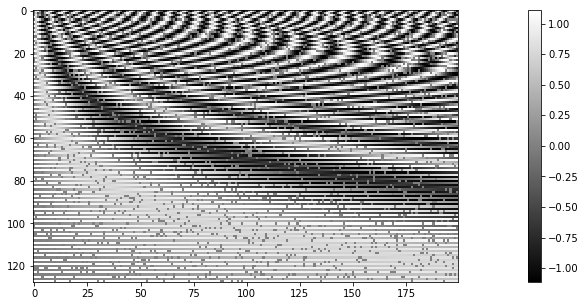

In [14]:
fg, ax = plt.subplots(figsize=(25, 5))
plt.imshow(pe(torch.zeros((1, 200, 128))).squeeze().data.numpy().T, cmap=plt.cm.get_cmap("gray"))
plt.colorbar()

In [15]:
train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous=num_previous)
valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous=num_previous)

NameError: name 'num_previous' is not defined

In [ ]:
len(train_dataset)

In [ ]:
indices = np.arange(0, len(train_dataset))
np.random.RandomState(42).shuffle(indices)
indices

In [ ]:
train1_indices = indices[:int(len(indices) * 0.8)]
train2_indices = indices[int(len(indices) * 0.8):]

In [ ]:
print(len(train1_indices), len(train2_indices))

In [ ]:
train1_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train1_indices))
train2_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train2_indices))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# for index in train1_indices:
#     train2_indices -= {index + num_previous}
    
# for index in train2_indices:
#     train1_indices -= {index + num_previous}

In [ ]:
# print(len(train1_indices), len(train2_indices))

In [ ]:
# for index in list(train1_indices):
#     train1_indices |= {index + i for i in range(1, num_previous)}
    
# for index in list(train2_indices):
#     train2_indices |= {index + i for i in range(1, num_previous)}

In [ ]:
# print(len(train1_indices), len(train2_indices))

In [ ]:
net = XTXModel(
    61,
    60,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    num_previous=num_previous,
    dropout=dropout,
).to(device)

In [15]:
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [26]:
mask = torch.zeros(batch_size, num_previous, 1, dtype=torch.float32, device=device)
random_gen = torch.Generator(device=device)

max_balanced_loss = float("inf")

for epoch in range(60):
    print(f"Epoch: {epoch}")

    net.train()
    train_losses = []
    for i, batch in enumerate(train1_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        mask.bernoulli_(0.3)
        mask_slice = mask[: x.size(0), :, :]
        x_in = torch.cat([1 - mask_slice, x * mask_slice.expand_as(x)], dim=2)
        optimizer.zero_grad()
        x_out = net(x_in)
        loss = criterion(x_out, x)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if i % 100 == 0:
            print(loss)
    train_loss = sum(train_losses) / len(train_losses)

    net.eval()
    random_gen.manual_seed(42)
    val_losses = []
    for i, batch in enumerate(valid_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        mask.bernoulli_(0.3, generator=random_gen)
        mask_slice = mask[: x.size(0), :, :]
        x_in = torch.cat([1 - mask_slice, x * mask_slice.expand_as(x)], dim=2)
        with torch.no_grad():
            x_out = net(x_in)
        loss = criterion(
            x_out[(1 - mask_slice).to(torch.bool).expand_as(x)],
            x[(1 - mask_slice).to(torch.bool).expand_as(x)],
        )
        val_losses.append(loss.item())
    val_loss = sum(val_losses) / len(val_losses)
    balanced_loss = 0.8 * val_loss + 0.2 * train_loss

    print(
        f"Train: {train_loss:.6f}, Valid: {val_loss:.6f}, Balanced: {balanced_loss:.6f}"
    )
    if balanced_loss > max_balanced_loss:
        break
    else:
        max_balanced_loss = balanced_loss

Epoch: 0
tensor(0.6822, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2605, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2440, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2336, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2248, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2226, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2292, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2153, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2163, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2041, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2014, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.2011, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.1952, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.1953, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.1892, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.1884, device='cuda:1', grad_fn=<L1LossBackward>)
tensor(0.1842, device='cuda:1', grad_fn=<L1LossBackward>)
tenso

In [27]:
# torch.save(net.state_dict(), NOTEBOOK_PATH.joinpath(f"bert_011.pt"))

In [ ]:
net2 = XTXModel2(
    d_model=d_model,
    output_size=1,
    dim_feedforward=dim_feedforward,
    transformer=net,
    dropout=dropout,
).to(device)

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.Adam(net2.parameters(), lr=0.0005, weight_decay=0)

In [35]:
mask = torch.zeros(batch_size, num_previous, 1, dtype=torch.float32, device=device)
mask[:, 1:, :] = 1.0

mask2 = torch.zeros(batch_size, 1, 60, dtype=torch.float32, device=device)

max_balanced_score = -float("inf")

for epoch in range(60):
    print(f"Epoch: {epoch}")

    net2.train()
    net2.transformer.eval()
    train_scores = []
    for i, batch in enumerate(train2_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        mask2_slice = mask2[: x.size(0), :, :]
        x = torch.cat([mask2_slice, x[:, :-1, :]], dim=1)
        mask_slice = mask[: x.size(0), :, :]
        x_in = torch.cat([1 - mask_slice, x * mask_slice.expand_as(x)], dim=2)
        optimizer.zero_grad()
        x_out = net2(x_in)
        loss = criterion(x_out[:, 0, :], y[:, 0, :])
        loss.backward()
        optimizer.step()

        score = 1 - ((y[:, 0, :] - x_out[:, 0, :]) ** 2).sum() / (y[:, 0, :] ** 2).sum()
        train_scores.append(score.item())
        if i % 100 == 0:
            print(loss, f"{score:.4f}")
    train_score = sum(train_scores) / len(train_scores)

    net.eval()
    x_out_lst = []
    y_lst = []
    for i, batch in enumerate(valid_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        mask2_slice = mask2[: x.size(0), :, :]
        x = torch.cat([mask2_slice, x[:, :-1, :]], dim=1)
        mask_slice = mask[: x.size(0), :, :]
        x_in = torch.cat([1 - mask_slice, x * mask_slice.expand_as(x)], dim=2)
        with torch.no_grad():
            x_out = net2(x_in)
        x_out_lst.append(x_out[:, 0, :].squeeze().squeeze().to(cpu).data.numpy())
        y_lst.append(y[:, 0, :].squeeze().to(cpu).data.numpy())
    x_out = np.hstack(x_out_lst)
    y = np.hstack(y_lst)
    valid_score = 1 - ((y - x_out) ** 2).sum() / (y ** 2).sum()
    balanced_score = 0.8 * valid_score + 0.2 * min(0.04, train_score)

    print(
        f"Train: {train_score:.6f}, Valid: {valid_score:.6f}, Balanced: {balanced_score:.6f}"
    )
    if balanced_score < max_balanced_score:
        break
    else:
        max_balanced_score = balanced_score

Epoch: 0
tensor(0.5960, device='cuda:1', grad_fn=<L1LossBackward>) -0.1130
tensor(0.5534, device='cuda:1', grad_fn=<L1LossBackward>) -0.0001
tensor(0.5627, device='cuda:1', grad_fn=<L1LossBackward>) 0.0006
tensor(0.5601, device='cuda:1', grad_fn=<L1LossBackward>) 0.0014
tensor(0.5765, device='cuda:1', grad_fn=<L1LossBackward>) 0.0024
Train: 0.000339, Valid: -0.004155, Balanced: -0.003256
Epoch: 1
tensor(0.5321, device='cuda:1', grad_fn=<L1LossBackward>) 0.0034
tensor(0.5370, device='cuda:1', grad_fn=<L1LossBackward>) 0.0056
tensor(0.5442, device='cuda:1', grad_fn=<L1LossBackward>) 0.0062
tensor(0.5538, device='cuda:1', grad_fn=<L1LossBackward>) 0.0059
tensor(0.5359, device='cuda:1', grad_fn=<L1LossBackward>) 0.0005
Train: 0.003708, Valid: -0.004187, Balanced: -0.002608
Epoch: 2
tensor(0.5507, device='cuda:1', grad_fn=<L1LossBackward>) 0.0055
tensor(0.5771, device='cuda:1', grad_fn=<L1LossBackward>) 0.0047
tensor(0.5493, device='cuda:1', grad_fn=<L1LossBackward>) 0.0040
tensor(0.5358, d

In [23]:
np.r_[0, np.cumsum(valid_df["y"]).values].shape

(600001,)

In [16]:
from scipy import stats

In [17]:
train_df["y_cumsum"] = np.cumsum(train_df["y"]).values
valid_df["y_cumsum"] = np.cumsum(valid_df["y"]).values

In [18]:
assert ((valid_df["y_cumsum"].values[1:] - valid_df["y_cumsum"].values[:-1]) == valid_df["y"].values[1:]).all()

In [19]:
train_df["midRate"] = (train_df["askRate0"] + train_df["bidRate0"]) / 2
valid_df["midRate"] = (valid_df["askRate0"] + valid_df["bidRate0"]) / 2

In [20]:
train_df["gapBid"] = (train_df["askSize0"] - train_df["bidSize0"])
valid_df["gapBid"] = (valid_df["askSize0"] - valid_df["bidSize0"])

In [21]:
# Normalize range
train_df["midRate_normed"] = (
    (train_df["midRate"] - train_df["midRate"].values[0])
    / (train_df["midRate"].max() - train_df["midRate"].min())
    * (train_df["y_cumsum"].max() - train_df["y_cumsum"].min())
)

valid_df["midRate_normed"] = (
    (valid_df["midRate"] - valid_df["midRate"].values[0])
    / (train_df["midRate"].max() - train_df["midRate"].min())
    * (train_df["y_cumsum"].max() - train_df["y_cumsum"].min())
)

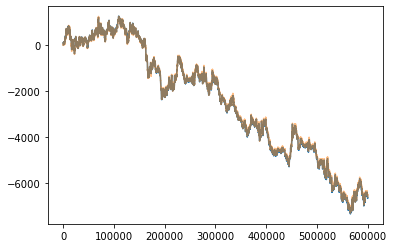

In [22]:
plt.plot(valid_df["y_cumsum"].values)
plt.plot(valid_df["midRate_normed"].values, alpha=0.5)
# plt.xlim(0, 100000)
# plt.ylim(-100, 500)

In [23]:
train_df["midRate_normed_tick"] = (
    np.r_[0, train_df["midRate_normed"].values[1:] - train_df["midRate_normed"].values[:-1]]
)
valid_df["midRate_normed_tick"] = (
    np.r_[0, valid_df["midRate_normed"].values[1:] - valid_df["midRate_normed"].values[:-1]]
)

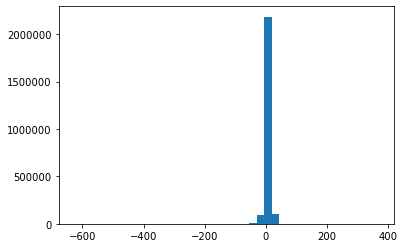

In [24]:
_ = plt.hist(train_df["midRate_normed_tick"], bins=40)

In [25]:
train_df["y"].std()

0.7329486431122653

In [26]:
train_df["midRate_normed_tick"].std() * train_df["y"].std()

6.0307731690733

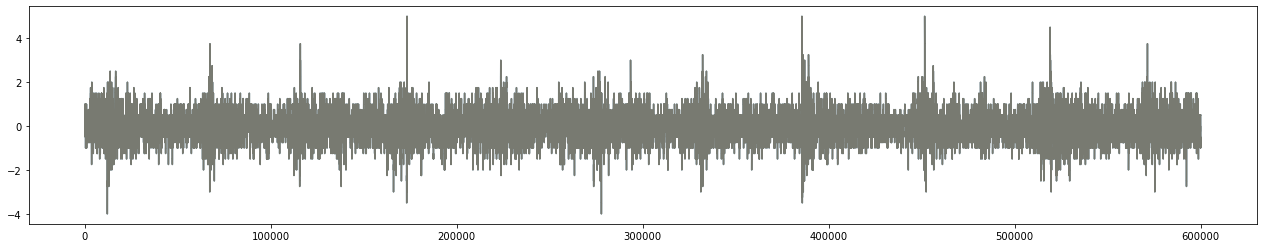

In [27]:
fg, ax = plt.subplots(figsize=(22, 4))
plt.plot(valid_df["y_cumsum"].values[1:] - valid_df["y_cumsum"].values[:-1])
plt.plot(valid_df["y"].values[:-1], alpha=0.4)

In [28]:
tick_mult = (valid_df["y"].max() - valid_df["y"].min()) / (valid_df["midRate_normed_tick"].max() - valid_df["midRate_normed_tick"].min())

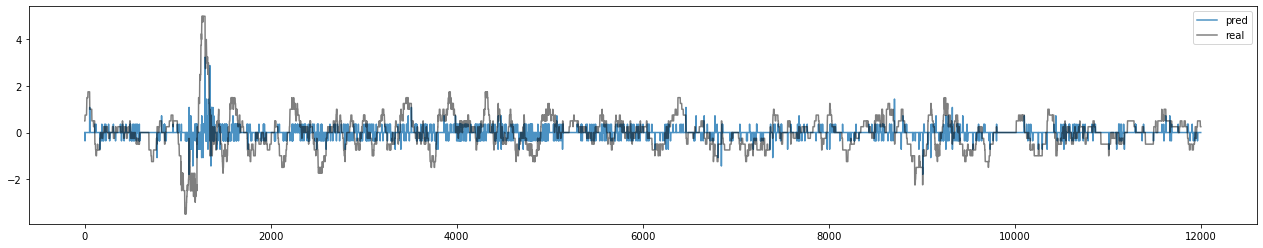

In [29]:
fg, ax = plt.subplots(figsize=(22, 4))
sub = slice(172_000, 184_000)
plt.plot(valid_df["midRate_normed_tick"].values[sub] * tick_mult, alpha=0.8, label="pred")
plt.plot(valid_df["y"].values[sub], alpha=0.5, color='k', label="real")
plt.legend()

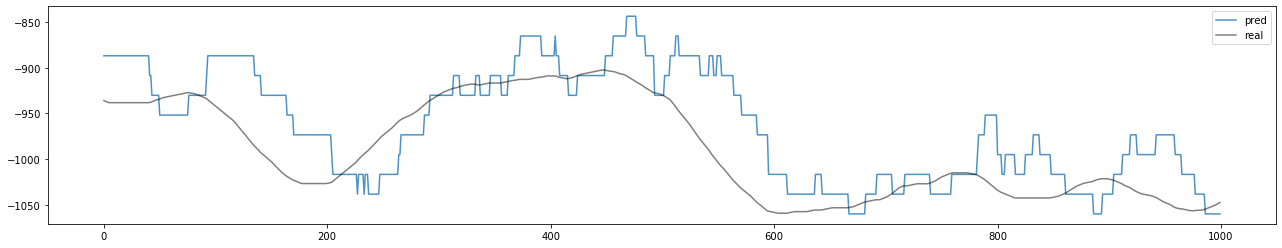

In [35]:
fg, ax = plt.subplots(figsize=(22, 4))
sub = slice(174_000, 175_000)
plt.plot(valid_df["midRate_normed"].values[sub], alpha=0.8, label="pred")
plt.plot(valid_df["y_cumsum"].values[sub], alpha=0.5, color='k', label="real")
plt.legend()

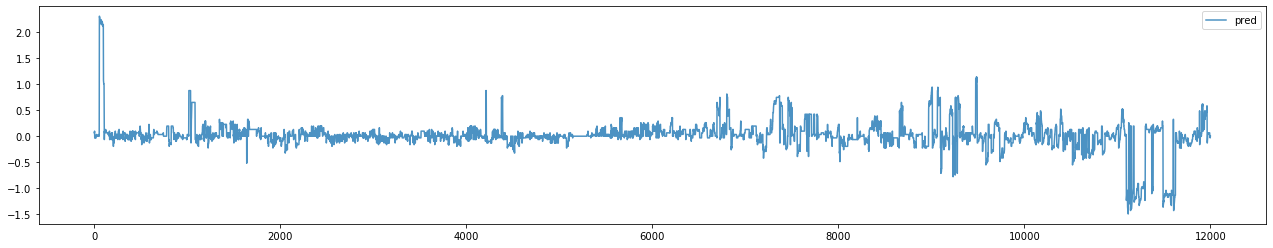

In [78]:
fg, ax = plt.subplots(figsize=(22, 4))
sub = slice(172_000, 184_000)
plt.plot(valid_df["gapBid"].values[sub], alpha=0.8, label="pred")
plt.legend()

In [71]:
i = 1
stats.pearsonr(valid_df["y_cumsum"].values[i:], valid_df["midRate_normed"].values[:-i])

(0.9999091781832208, 0.0)

In [45]:
from scipy import stats

In [46]:
stats.pearsonr(valid_df["y"].values, valid_df["midRate_normed_tick"].values)

(-0.024500528234679776, 2.4565149023615935e-80)

(-0.024500528234679776, 2.4565149023615935e-80)

In [84]:
print(0, stats.pearsonr(valid_df["y"].values, valid_df["midRate_normed_tick"].values))
for i in range(1, 100):
    print(i, stats.pearsonr(valid_df["y"].values[:-i], valid_df["midRate_normed_tick"].values[i:]))

0 (-0.024500528234679776, 2.4565149023615935e-80)
1 (0.10657194211290731, 0.0)
2 (0.10189484993214273, 0.0)
3 (0.09935053566854495, 0.0)
4 (0.09604686770110324, 0.0)
5 (0.09409021856720452, 0.0)
6 (0.09186724377756637, 0.0)
7 (0.09047845301159714, 0.0)
8 (0.08929215456408389, 0.0)
9 (0.08885504564271082, 0.0)
10 (0.087802998447967, 0.0)
11 (0.08710311704155524, 0.0)
12 (0.0871075693278534, 0.0)
13 (0.08740980060963727, 0.0)
14 (0.0875529203109656, 0.0)
15 (0.086597707296171, 0.0)
16 (0.08590001823163143, 0.0)
17 (0.08659560599457904, 0.0)
18 (0.08651861836192326, 0.0)
19 (0.08594859023594625, 0.0)
20 (0.08559646780314749, 0.0)
21 (0.08560972354064275, 0.0)
22 (0.08538966511153742, 0.0)
23 (0.08461273355139928, 0.0)
24 (0.08445870665229921, 0.0)
25 (0.08485054769900462, 0.0)
26 (0.0852203783930607, 0.0)
27 (0.08540751957534887, 0.0)
28 (0.08506419946154854, 0.0)
29 (0.08519631361366227, 0.0)
30 (0.08523598223735804, 0.0)
31 (0.08535489011777182, 0.0)
32 (0.08560146138818361, 0.0)
33 (0.

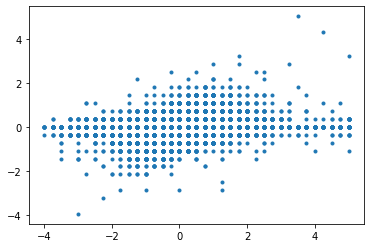

In [256]:
plt.plot(valid_df["y"].values[:-1], valid_df["midRate_normed_tick"].values[1:] * tick_mult, '.')

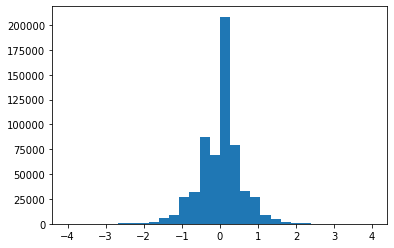

In [250]:
_ = plt.hist(valid_df["y"].values - valid_df["midRate_normed_tick"].values * tick_mult, bins=30, range=(-4, 4))

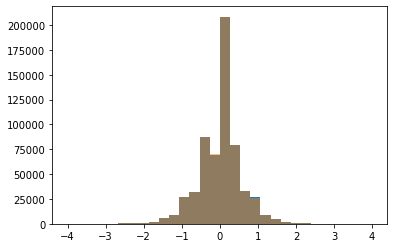

In [251]:
_ = plt.hist(valid_df["y"].values - valid_df["midRate_normed_tick"].values * tick_mult, bins=30, range=(-4, 4))
_ = plt.hist(valid_df["y"].values[1:] - valid_df["midRate_normed_tick"].values[:-1] * tick_mult, bins=30, range=(-4, 4), alpha=0.5)

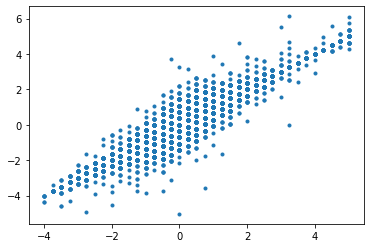

In [248]:
plt.plot(valid_df["y"], valid_df["resid"], '.')

In [243]:
valid_df["resid"] = valid_df["y"].values - valid_df["midRate_normed_tick"].values * tick_mult

In [245]:
valid_df.corr()["resid"]

askRate0              -0.004651
askRate1              -0.004562
askRate2              -0.004545
askRate3              -0.004517
askRate4              -0.004469
askRate5              -0.004439
askRate6              -0.004414
askRate7              -0.004360
askRate8              -0.004359
askRate9              -0.004375
askRate10             -0.004394
askRate11             -0.004393
askRate12             -0.004487
askRate13             -0.004449
askRate14             -0.004436
bidRate0              -0.004792
bidRate1              -0.004705
bidRate2              -0.004676
bidRate3              -0.004656
bidRate4              -0.004718
bidRate5              -0.004715
bidRate6              -0.004704
bidRate7              -0.004749
bidRate8              -0.004762
bidRate9              -0.004763
bidRate10             -0.004819
bidRate11             -0.004910
bidRate12             -0.005225
bidRate13             -0.005257
bidRate14             -0.005052
askSize0              -0.066339
askSize1

In [199]:
valid_df["midRate_normed_tick"]

2399999    0.0
2400000    0.0
2400001    0.0
2400002    0.0
2400003    0.0
          ... 
2999994    0.0
2999995    0.0
2999996    0.0
2999997    0.0
2999998    0.0
Name: midRate_normed_tick, Length: 600000, dtype: float64

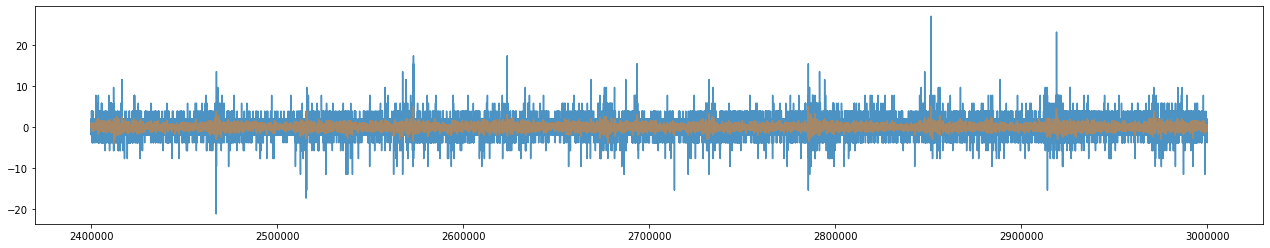

In [186]:
fg, ax = plt.subplots(figsize=(22, 4))
plt.plot(valid_df["midRate_normed_tick"] / train_df["midRate_normed_tick"].std() * train_df["y"].std(), alpha=0.8)
plt.plot(valid_df["y"], alpha=0.5)

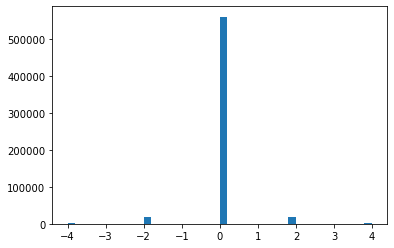

In [197]:
_ = plt.hist(
    valid_df["midRate_normed_tick"]
    / train_df["midRate_normed_tick"].std()
    * train_df["y"].std(),
    bins=40, range=(-4, 4)
)

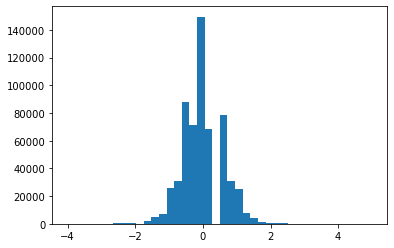

In [196]:
_ = plt.hist(
    valid_df["y"],
    bins=40,
)

In [194]:
(valid_df["midRate_normed_tick"]
    / train_df["midRate_normed_tick"].std()
    * train_df["y"].std())

2399999    0.0
2400000    0.0
2400001    0.0
2400002    0.0
2400003    0.0
          ... 
2999994    0.0
2999995    0.0
2999996    0.0
2999997    0.0
2999998    0.0
Name: midRate_normed_tick, Length: 600000, dtype: float64

In [179]:
(valid_df["midRate_normed_tick"].values / train_df["midRate_normed_tick"].std() * train_df["y"].std()).std()

0.6068951325086274

In [184]:
train_df["midRate_normed_tick"].var()

67.70159455519747

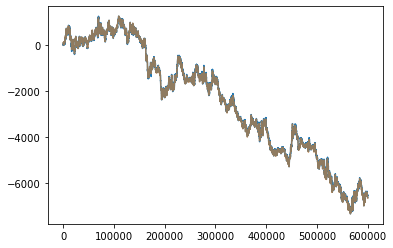

In [128]:
plt.plot(valid_df["midRate_normed"].values)
plt.plot(valid_df["y_cumsum"].values, alpha=0.5)

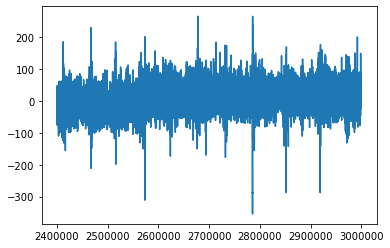

In [122]:
plt.plot(valid_df["midRate_normed"] - valid_df["y_cumsum"])

In [113]:
valid_df["midRate_normed_diff"] = np.r_[0, (valid_df["midRate_normed"].values[1:] - valid_df["midRate_normed"].values[:-1])]

In [114]:
valid_df["y"].values[1:]

array([0.  , 0.25, 0.25, ..., 0.5 , 0.5 , 0.5 ])

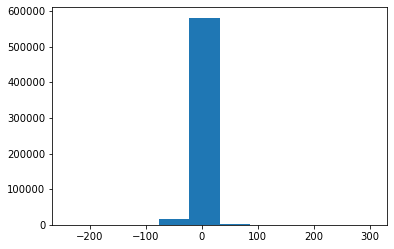

In [116]:
_ = plt.hist(valid_df["midRate_normed_diff"].values)

In [119]:
valid_df["midRate_normed_diff"] - valid_df["y"]

2399999    0.00
2400000    0.00
2400001   -0.25
2400002   -0.25
2400003   -0.25
           ... 
2999994   -0.50
2999995   -0.50
2999996   -0.50
2999997   -0.50
2999998   -0.50
Length: 600000, dtype: float64

In [73]:
stats.spearmanr(valid_df["askRate0"].values[1:] - valid_df["askRate0"].values[:-1], valid_df["y"].values[1:])

SpearmanrResult(correlation=-0.019044363425432486, pvalue=2.943073283122899e-49)

array([ 0.        ,  0.        ,  0.        , ..., -2.89285702,
       -2.89285702, -2.89285702])

In [78]:
valid_df["askRate0"].values

array([ 0.57795055,  0.57795055,  0.57795055, ..., -2.31490647,
       -2.31490647, -2.31490647])

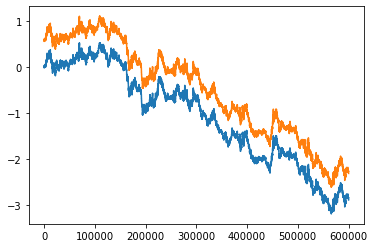

In [80]:
x = np.cumsum(valid_df["askRate0"].values[1:] - valid_df["askRate0"].values[0:-1])
y = valid_df["askRate0"].values

plt.plot(x)
plt.plot(y)

In [83]:
valid_df["y"]

2399999    0.00
2400000    0.00
2400001    0.25
2400002    0.25
2400003    0.25
           ... 
2999994    0.50
2999995    0.50
2999996    0.50
2999997    0.50
2999998    0.50
Name: y, Length: 600000, dtype: float64

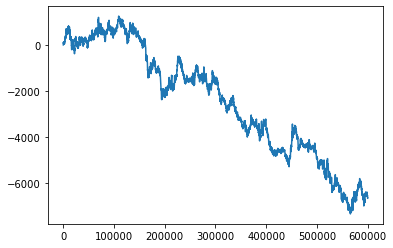

In [82]:
plt.plot(np.cumsum(valid_df["y"].values))

(2400000, 2500000)

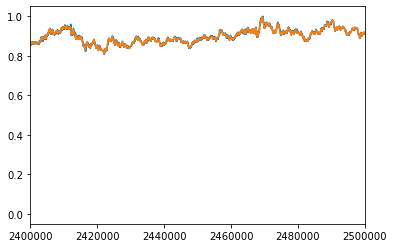

In [57]:
s = valid_df["askRate0"]
plt.plot((s - s.min()) / (s.max() - s.min()))

s = np.cumsum(valid_df["y"])
plt.plot((s - s.min()) / (s.max() - s.min()))

plt.xlim(2_400_000, 2_500_000)

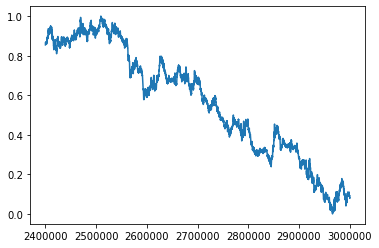

In [46]:
s = np.cumsum(valid_df["y"])
plt.plot((s - s.min()) / (s.max() - s.min()))

In [40]:
np.cumsum(valid_df["y"])

2399999       0.00
2400000       0.00
2400001       0.25
2400002       0.50
2400003       0.75
            ...   
2999994   -6635.50
2999995   -6635.00
2999996   -6634.50
2999997   -6634.00
2999998   -6633.50
Name: y, Length: 600000, dtype: float64